In [0]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import cv2
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
import os
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from datetime import datetime
import scipy.io
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torchvision.models as models

In [0]:
!mkdir 'data'
!mkdir 'data/train'
!mkdir 'data/test'
!unzip -q "drive/My Drive/DL_project/MAFA-Label-Test.zip" -d 'data/test/'
!unzip -q "drive/My Drive/DL_project/MAFA-Label-Train.zip" -d 'data/train/'
!unzip -q "drive/My Drive/DL_project/test-images.zip" -d 'data/test/'
!unzip -q "drive/My Drive/DL_project/train-images.zip" -d 'data/train/'

In [0]:
!mkdir 'train/'
!mkdir 'train/0'
!mkdir 'train/1'
!mkdir 'train/2'

In [0]:
from tqdm import trange

def cropImage(filename, picname, pic_in_pic_ind, labels, target_directory):
    """Crop image specified by filename to coordinates specified."""
    coords = labels[:4]
    if labels[12] == -1:
        labels[12] = 2
    if labels[13] == -1:
        labels[13] = 2
    good_position = (labels[12] == 1 or labels[12] == 2) and labels[13] == 3
    bad_position = (labels[12] == 1 or labels[12] == 2) and (labels[13] == 2 or labels[13] == 1)
    true_label = 0 if good_position else (2 if bad_position else 1)

    # Open image and get height and width
    im = Image.open('/'.join((filename, picname))).convert('RGB')
    w, h = im.width, im.height

    # Work out crop coordinates, top, left, bottom, right
    l = int(coords[0])
    t = int(coords[1])
    r = int(coords[0] + coords[2])
    b = int(coords[1] + coords[3])

    # Crop and save
    im = im.crop((l,t,r,b))
    newname = str(pic_in_pic_ind) + '_' + picname
    im.save('/'.join((target_directory, str(true_label), newname)))
    return im, true_label

In [5]:
image_data = scipy.io.loadmat('/content/data/train/LabelTrainAll.mat')['label_train'][0]
filename = '/content/data/train/images/'
target_directory = '/content/train/'

for pic_ind in trange(len(image_data)):
    for pic_in_pic_ind, (picname, im_labels) in enumerate(zip(image_data[pic_ind][1], image_data[pic_ind][2])):
        _, _ = cropImage(filename, picname, pic_in_pic_ind, im_labels.astype(np.int64), target_directory)

 46%|████▌     | 11939/25876 [01:40<01:46, 130.46it/s]/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
100%|██████████| 25876/25876 [03:11<00:00, 134.99it/s]


LABEL: Good Condition


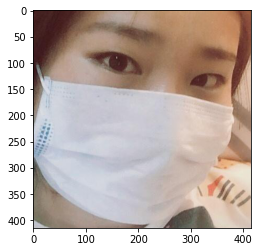

In [6]:
image_data = scipy.io.loadmat('/content/data/train/LabelTrainAll.mat')['label_train'][0]

filename = '/content/data/train/images/'
target_directory = '/content/train/'
pic_ind = np.random.choice(len(image_data))
pic_in_pic_ind = 0
labels_dict = {0: 'Good Condition', 1: 'No Mask', 2: 'Bad Condition'}
filename = '/content/data/train/images/'
picname = image_data[pic_ind][1][pic_in_pic_ind]
labels = image_data[pic_ind][2][pic_in_pic_ind].astype(np.int64)
image, true_label = cropImage(filename, picname, pic_in_pic_ind, labels, target_directory)
print('LABEL:', labels_dict[true_label])
plt.imshow(image)

In [0]:
def gaussian_blur(img):
    image = np.array(img)
    image_blur = cv2.GaussianBlur(image,(15,15),10)
    new_image = image_blur
    return new_image

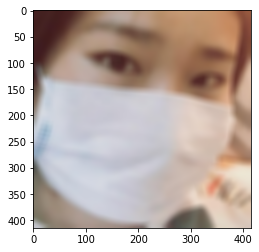

In [35]:
plt.imshow(gaussian_blur(image))

In [0]:
my_transform = { 'train' : transforms.Compose([transforms.Resize((224,224)),
                                               #transforms.Lambda(gaussian_blur),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                               ]),
                'test': transforms.Compose([transforms.Resize((224,224)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
                }

In [0]:
dataset = torchvision.datasets.ImageFolder('train', transform = my_transform['train'])
dataset_size = len(dataset)
train_size = int(dataset_size*0.7)
val_size = int(dataset_size*0.2)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [0]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight   

In [0]:
weights = make_weights_for_balanced_classes(train_dataset.dataset.imgs, len(train_dataset.dataset.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))    

In [0]:
batch_size = 32
train_batch_gen = torch.utils.data.DataLoader(train_dataset.dataset, 
                                              batch_size=batch_size,
                                              sampler=sampler,
                                              num_workers=1)
val_batch_gen = torch.utils.data.DataLoader(val_dataset.dataset, 
                                           batch_size=batch_size,
                                            sampler=sampler,
                                           num_workers=1)

In [62]:
model = models.resnet18(pretrained=True)
for layer, param in model.named_parameters():
    param.requires_grad = True

model.fc = torch.nn.Sequential(nn.Linear(512, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 3),
                                 nn.Softmax(dim=-1))
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
def setup_experiment(title, logdir="./tb"):
    experiment_name = "{}@{}".format(title, datetime.now().strftime("%d.%m.%Y-%H:%M:%S"))
    writer = SummaryWriter(log_dir=os.path.join(logdir, experiment_name))
    best_model_path = f"{title}.best.pth"
    return writer, experiment_name, best_model_path

In [0]:
class Criterion():
  def __init__(self, weights):
    self.weights = weights
    pass
  def __call__(self, y_pred, y):
    loss = - (y* (torch.log(y_pred)*self.weights)).mean()
    return loss

In [65]:
criterion = Criterion(torch.ones(3).cuda())
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
writer, experiment_name, best_model_path = setup_experiment('MultiLabel_resnet_finetuned_v2', logdir="./tb")
print(f"Experiment name: {experiment_name}")

Experiment name: MultiLabel_resnet_finetuned_v2@02.06.2020-18:43:55


In [66]:
%load_ext tensorboard
%tensorboard --logdir tb

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [0]:
def compute_accuracy(logits, y_true):
    y_pred = torch.argmax(logits, dim=1)
    accuracy = (y_pred == y_true).float().mean()
    return accuracy

In [0]:
def onehot_encoding(y):
    Y = torch.zeros((len(y), 3))
    Y[torch.arange(len(y)), y] = 1
    return Y

In [0]:
def run_epoch(model, iterator, optimizer, criterion, phase='train', epoch=0, writer=None):
    is_train = (phase == 'train')
    if is_train:
        model.train()
    else:
        model.eval()
     
    with torch.set_grad_enabled(is_train):
        accuracy_batch = []
        loss_batch = []
        for i, batch in enumerate(iterator):
          X, y = batch[0].cuda(), batch[1].cuda()
          y_encoded = onehot_encoding(y).cuda()
          output = model(X)
          loss = criterion(output, y_encoded)
          accuracy = compute_accuracy(output, y)
          loss_batch.append(loss.item())
          accuracy_batch.append(accuracy.item())
          if is_train:
              optimizer.zero_grad()
              loss.backward()
              optimizer.step()
    accuracy_overall = np.mean(accuracy_batch)*100
    loss_overall = np.mean(loss_batch).item()
    if writer is not None:
          writer.add_scalar(f"Loss/{phase}", loss_overall, epoch)
          writer.add_scalar(f"Accuracy/{phase}", accuracy_overall, epoch)
    return loss_overall, accuracy_overall

In [70]:
n_epochs = 6
best_val_acc = float('-inf')
for epoch in tqdm(range(n_epochs)):    
    train_loss, train_accuracy = run_epoch(model, train_batch_gen, optimizer, criterion, phase='train', epoch=epoch, writer=writer)
    val_loss, val_accuracy = run_epoch(model, val_batch_gen, None, criterion, phase='val', epoch=epoch, writer=writer)
    
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), best_model_path)
    
    target = []
    y_pred = []
    for X, y in test_dataset:
        out = model(X[None, :].cuda())
        target.append(y)
        y_pred.append(out.argmax().cpu().item())
    
    df_cm = pd.DataFrame(confusion_matrix(np.array(target), np.array(y_pred),  normalize = 'true'), columns = ['Good mask', 'No mask', 'Bad mask'], 
                        index = ['Good mask', 'No mask', 'Bad mask'])
    fig = plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap = 'Blues')
    writer.add_figure('Confusion_matrix/Test', fig, epoch )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
best_val_acc, best_model_path

(99.76050679851669, 'MultiLabel_resnet_finetuned_v2.best.pth')

In [72]:
model = models.resnet18()
model.fc = torch.nn.Sequential(nn.Linear(512, 32),
                                 nn.ReLU(),
                                 nn.Linear(32, 3),
                                 nn.Softmax(dim=-1))
model.load_state_dict(torch.load(best_model_path))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
target = []
y_pred = []
for X, y in test_dataset:
    out = model(X[None, :].cuda())
    target.append(y)
    y_pred.append(out.argmax().cpu().item())

In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(np.array(target), np.array(y_pred))

0.9969088098918083

In [0]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [77]:
len(np.where(np.array(target)!=np.array(y_pred))[0])/ len(test_dataset)

0.0030911901081916537

In [78]:
len(np.where(np.array(target)!=np.array(y_pred))[0])

8

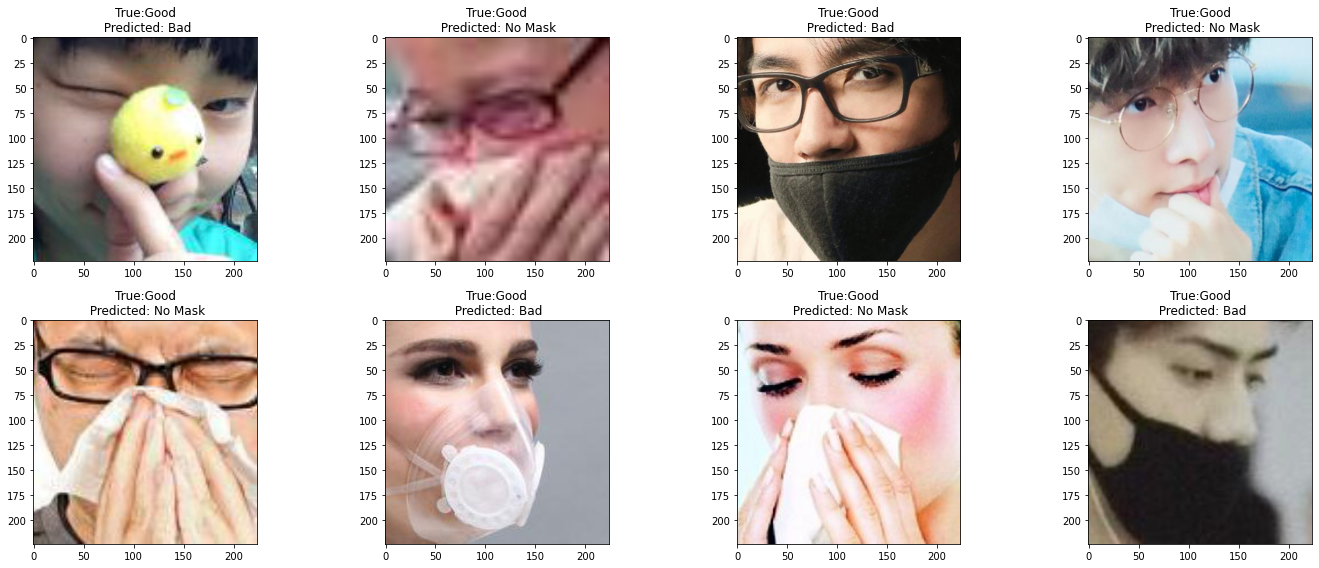

In [83]:
labels_dict = {0: 'Good', 1: 'No Mask', 2: 'Bad'}
fig, axs = plt.subplots(2, 4, figsize = (20,8))
ax = axs.flatten()
inds = np.random.choice(np.where(np.array(target)!=np.array(y_pred))[0], 8, replace=False)
for i, ind in enumerate(inds):
  unorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  x = unorm(test_dataset[ind][0])
  ax[i].imshow(x.transpose(0,2).transpose(0,1))
  ax[i].set_title('True:'  + labels_dict[test_dataset[ind][1]] + '\n Predicted: '  + labels_dict[y_pred[ind]])

fig.tight_layout()

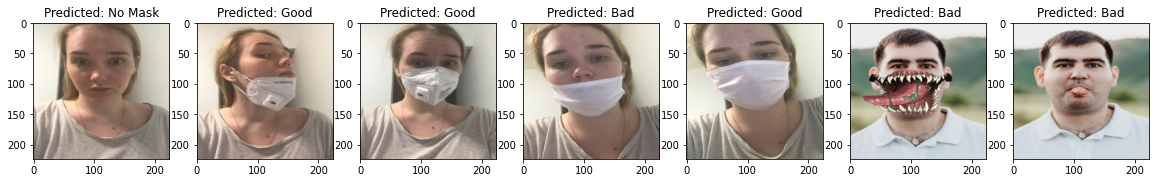

In [90]:
fig, axs = plt.subplots(1,7, figsize= (20,7))
ax = axs.flatten()
unorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
for i in range(11, 18):
  im = Image.open(f'{i}.jpg').convert('RGB')
  vals = my_transform['train'](im)
  out = model(vals[None, :].cuda())
  pred = out.argmax(dim=1).item()
  ax[i-11].imshow(unorm(vals).transpose(0,2).transpose(0,1))
  ax[i-11].set_title(f'Predicted: {labels_dict[pred]}')